# Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import PIL
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from random import randrange

In [3]:
cd drive/MyDrive/Colab\ Notebooks/mnist_detection

/content/drive/MyDrive/Colab Notebooks/mnist_detection


# Dataset

In [4]:
train_df = pd.read_csv("./data/train.csv")
# test_df = pd.read_csv("./data/test.csv")

In [5]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=0)

In [6]:
def show_img_from_df(df, ind):
    plt.imshow(np.reshape(np.array(df.iloc[ind, 1:]), (28, 28)), cmap="gray")

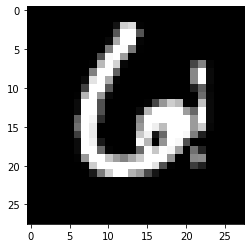

In [7]:
show_img_from_df(train_df, 0)

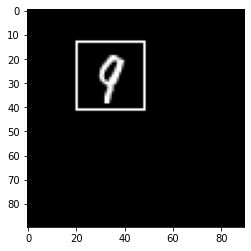

In [8]:
new_size = 90

df = train_df
ind = randrange(1000)

img = np.reshape(np.array(df.iloc[ind, 1:]), (28, 28))

new_img = np.zeros((new_size, new_size))

# randomly select a bottom left corner to use for img
x_min = randrange(new_size - img.shape[0])
y_min = randrange(new_size - img.shape[0])

x_max = x_min + img.shape[0]
y_max = y_min + img.shape[0]

x_center = x_min + (x_max - x_min) / 2
y_center = y_min + (y_max - y_min) / 2

new_img[x_min:x_max, y_min:y_max] = img
new_img = cv2.rectangle(new_img, (y_max, x_min), (y_min, x_max), 255, 1)

plt.imshow(new_img, cmap="gray")
# plt.plot(y_center, x_center, "og", markersize=10)
plt.show()

In [9]:
class CustomDataset(Dataset):
    def __init__(self, df, test=False):
        self.df = df
        self.test = test

    def __getitem__(self, index):
        if self.test:
            image = np.reshape(np.array(self.df.iloc[index, :]), (28, 28)) / 255.
        else:
            image = np.reshape(np.array(self.df.iloc[index, 1:]), (28, 28)) / 255.

        # create the new image
        new_img = np.zeros((90, 90))

        # randomly select a bottom left corner to use for img
        x_min = randrange(90 - image.shape[0])
        y_min = randrange(90 - image.shape[0])

        x_max = x_min + image.shape[0]
        y_max = y_min + image.shape[0]

        new_img[x_min:x_max, y_min:y_max] = image
        new_img = np.reshape(new_img, (1, 90, 90))

        label = [int(self.df.iloc[index, 0]), np.array([y_max, x_min, y_min, x_max]).astype("float32")]

        return new_img, label

    def __len__(self):
        return len(self.df)

In [10]:
train_data = CustomDataset(train_df)
valid_data = CustomDataset(val_df)

train_dataloader = DataLoader(
    train_data,
    batch_size=64,
    shuffle=True
)

valid_dataloader = DataLoader(
    valid_data,
    batch_size=64,
    shuffle=True
)

In [11]:
cx = next(iter(train_dataloader))

Image shape: [1, 90, 90]
Digit: 3
point: (55, 15, 27, 43)


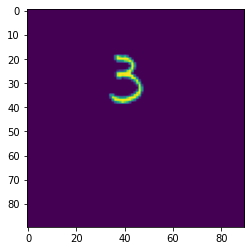

In [12]:
index = randrange(63)
x_min, y_min, x_max, y_max = cx[1][1][index]

plt.imshow(np.reshape(cx[0][index], (90, 90)))

print("Image shape: " + str(list(cx[0][index].shape)))
print("Digit: " + str(int(cx[1][0][index])))
print(f"point: ({int(x_min)}, {int(y_min)}, {int(x_max)}, {int(y_max)})")

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Model

In [14]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()

        self.conv0 = nn.Conv2d(1, 16, 3, padding=2)
        self.pool0 = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(16, 16, 3, padding=3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16*25*25, 256),
            nn.ReLU()
        )

        self.linear = nn.Linear(256, 10)
        self.linear_bbox = nn.Linear(256, 4)

    def forward(self, x):
        x = self.conv0(x)
        x = self.pool0(x)
        x = F.relu(x)

        x = self.conv1(x)
        x = self.pool1(x)
        x = F.relu(x)

        x = self.flatten(x)
        x = self.linear_relu_stack(x)

        logits = self.linear(x)
        bbox = self.linear_bbox(x)

        return logits, bbox

In [15]:
model = CustomNet().to(device)
model

CustomNet(
  (conv0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10000, out_features=256, bias=True)
    (1): ReLU()
  )
  (linear): Linear(in_features=256, out_features=10, bias=True)
  (linear_bbox): Linear(in_features=256, out_features=4, bias=True)
)

# Training

In [16]:
loss_fn = nn.CrossEntropyLoss()
loss_mse = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(), lr=1e-3)
alpha = 100
beta = 1

In [17]:
def train(model, dataloader, loss_fn, loss_mse, optimizer, alpha, beta):
    model.train()
    size = len(dataloader.dataset)

    loss_cls_list = []
    loss_point_list = []

    for batch, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        label_class = labels[0].to(device)
        label_point = labels[1].to(device)

        pred_cls, pred_point = model(inputs.float())

        loss = alpha*loss_fn(pred_cls, label_class) + beta*loss_mse(pred_point, label_point.float())
        loss_cls = loss_fn(pred_cls, label_class)
        loss_point = loss_mse(pred_point, label_point)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch != 0) and (batch % 100 == 0):
            loss = loss.item()
            current = batch*len(inputs)

            loss_cls = loss_cls.item()
            loss_point = loss_point.item()

            loss_cls_list.append(loss_cls)
            loss_point_list.append(loss_point)

            print(f"main loss: {loss:>7f} [{current:>5d}/{size:5d}]")
            print(f"Digit prediction loss: {loss_cls:>7f} [{current:>5d}/{size:>5d}]")
            print(f"Coordinate prediction loss: {loss_point:>7f} [{current:>5d}/{size:>5d}]")
            print("-"*20)

In [18]:
def test(model, dataloader, loss_fn, loss_mse, alpha, beta):
    model.eval()
    
    size = len(dataloader.dataset)
    loss, loss_cls, loss_point, correct = 0, 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            label_cls = labels[0].to(device)
            label_point = labels[1].to(device)

            pred_cls, pred_point = model(inputs.float())

            loss += alpha * loss_fn(pred_cls, label_cls).item() + beta * loss_mse(pred_point, label_point.float()).item()
            loss_cls += loss_fn(pred_cls, label_cls).item()
            loss_point += loss_mse(pred_point, label_point.float()).item()

            correct += (pred_cls.argmax(1) == label_cls).type(torch.float).sum().item()
    
    loss /= size
    loss_cls /= size
    loss_point /= size
    correct /= size

    print(f"Test Error:\n Accuracy: {(100*correct):>0.1f}%, Avg digit loss: {loss_cls:>8f}, Avg coordinate loss: {loss_point:>8f}\n")


In [19]:
num_epoch = 10

for t in range(num_epoch):
    print(f"Epoch [{t+1}/{num_epoch}] \n")
    train(model, train_dataloader, loss_fn, loss_mse, optimizer, alpha, beta)
    test(model, valid_dataloader, loss_fn, loss_mse, alpha, beta)

print("Done!")

Epoch [1/10] 

main loss: 317.386932 [ 6400/33600]
Digit prediction loss: 2.498165 [ 6400/33600]
Coordinate prediction loss: 67.570412 [ 6400/33600]
--------------------
main loss: 231.542664 [12800/33600]
Digit prediction loss: 2.119824 [12800/33600]
Coordinate prediction loss: 19.560265 [12800/33600]
--------------------
main loss: 222.612473 [19200/33600]
Digit prediction loss: 2.124226 [19200/33600]
Coordinate prediction loss: 10.189866 [19200/33600]
--------------------
main loss: 241.435318 [25600/33600]
Digit prediction loss: 2.301992 [25600/33600]
Coordinate prediction loss: 11.236151 [25600/33600]
--------------------
main loss: 230.220413 [32000/33600]
Digit prediction loss: 2.239566 [32000/33600]
Coordinate prediction loss: 6.263774 [32000/33600]
--------------------
Test Error:
 Accuracy: 27.3%, Avg digit loss: 0.031301, Avg coordinate loss: 0.134079

Epoch [2/10] 

main loss: 217.623474 [ 6400/33600]
Digit prediction loss: 2.095919 [ 6400/33600]
Coordinate prediction loss:

# Test

In [20]:
test_df = pd.read_csv("./data/test.csv")

In [21]:
class TestDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __getitem__(self, index):
        image = np.reshape(np.array(self.df.iloc[index, :]), (28, 28)) / 255.

        # create the new image
        new_img = np.zeros((90, 90))

        # randomly select a bottom left corner to use for img
        x_min = randrange(90 - image.shape[0])
        x_max = x_min + image.shape[0]
        y_min = randrange(90 - image.shape[0])
        y_max = y_min + image.shape[0]

        new_img[x_min:x_max, y_min:y_max] = image
        new_img = np.reshape(new_img, (1, 90, 90))

        return new_img

    def __len__(self):
        return len(self.df)

In [22]:
test_dataset = TestDataset(test_df)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=True
)

In [23]:
inputs = next(iter(test_dataloader))

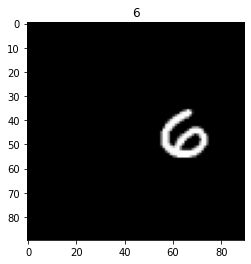

In [24]:
index = randrange(63)

with torch.no_grad():
    pred_cls, pred_point = model(inputs.to(device).float())
    pred_cls = np.argmax(pred_cls[index].cpu().detach().numpy())

img = np.reshape(inputs[index].cpu().detach().numpy(), (90, 90))

y_max, x_min, y_min, x_max = int(pred_point[index][0]), int(pred_point[index][1]), int(pred_point[index][2]), int(pred_point[index][3])

new_img = img.copy()
new_img = cv2.rectangle(new_img, (y_max, x_min), (y_min, x_max), 255, 1)


plt.imshow(img, cmap="gray")
plt.title(f"{pred_cls}")
plt.show()

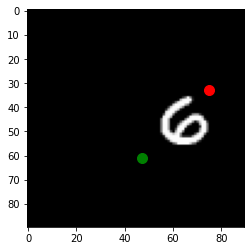

Digit: 6
75, 33, 47, 61


In [25]:
new_img = img.copy()
# new_img = cv2.rectangle(new_img, (y_max, x_min), (y_min, x_max), 255, 1)

plt.imshow(new_img, cmap="gray")
plt.plot(y_max, x_min, "or", markersize=10)
plt.plot(y_min, x_max, "og", markersize=10)
plt.show()

print("Digit:", int(pred_cls))
# print("Point:", pred_point)
print(f"{y_max}, {x_min}, {y_min}, {x_max}")